<a href="https://colab.research.google.com/github/lukavujeva/ast425/blob/main/Marchal_et_al_2022b_forpaper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mapping a lower limit on the mass fraction of the cold neutral medium using Fourier transformed HI 21cm emission line spectra



In [1]:
!pip install ROHSApy
!pip install marchalib -U
!pip install fBms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 5.2 MB/s eta 0:00:00


In [25]:
#!wget https://www.cita.utoronto.ca/GHIGLS/FITS/GHIGLS_UMAEAST_Tb.fits

!wget https://www.cita.utoronto.ca/~vujeva/GHIGLS_NCPL_Tb_CNM_IVC_n6_final.fits
!wget https://www.cita.utoronto.ca/~vujeva/GHIGLS_NCPL_Tb_WNM_IVC_n6_final.fits

!wget https://www.cita.utoronto.ca/~vujeva/GHIGLS_NCPL_Tb_INPAINTEDFILTERED.fits

--2023-07-20 22:15:54--  https://www.cita.utoronto.ca/~vujeva/GHIGLS_NCPL_Tb_CNM_IVC_n6_final.fits
Resolving www.cita.utoronto.ca (www.cita.utoronto.ca)... 128.100.76.81
Connecting to www.cita.utoronto.ca (www.cita.utoronto.ca)|128.100.76.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9852480 (9.4M)
Saving to: ‘GHIGLS_NCPL_Tb_CNM_IVC_n6_final.fits.1’

GHIGLS_NCPL_Tb_CNM_ 100%[===================>]   9.40M  5.42MB/s    in 1.7s    

2023-07-20 22:15:58 (5.42 MB/s) - ‘GHIGLS_NCPL_Tb_CNM_IVC_n6_final.fits.1’ saved [9852480/9852480]

--2023-07-20 22:15:58--  https://www.cita.utoronto.ca/~vujeva/GHIGLS_NCPL_Tb_WNM_IVC_n6_final.fits
Resolving www.cita.utoronto.ca (www.cita.utoronto.ca)... 128.100.76.81
Connecting to www.cita.utoronto.ca (www.cita.utoronto.ca)|128.100.76.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9852480 (9.4M)
Saving to: ‘GHIGLS_NCPL_Tb_WNM_IVC_n6_final.fits.1’

GHIGLS_NCPL_Tb_WNM_ 100%[===================>]   9.

In [88]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy.fft import rfftn

from ROHSApy import ROHSA
import marchalib as ml

# name = "CNM"
fitsname1 = "GHIGLS_NCPL_Tb_CNM_IVC_n6_final.fits"

fitsname2 = "GHIGLS_NCPL_Tb_WNM_IVC_n6_final.fits"

fitsname3 = 'GHIGLS_NCPL_Tb_INPAINTEDFILTERED.fits'

hdu1 = fits.open(fitsname1)
hdr1 = hdu1[0].header
data1 = hdu1[0].data

hdu2 = fits.open(fitsname2)
hdr2 = hdu2[0].header
data2 = hdu2[0].data

hdu3 = fits.open(fitsname3)
hdr3 = hdu3[0].header
data3 = hdu3[0].data[0]


#for cube

hdr3['CRPIX1'] -= 197
hdr3['CRPIX2'] -= 246
hdr3['CRPIX3'] -= 215 + 85

cube = hdu3[0].data[0][215:369,246:374, 197:325]
cube = cube[85:, :, :]

# cube = data1+data2 #+cubetot

core = ROHSA(cube, hdr1)

In [89]:
#Get sub velocity range
v = core.v
dv = np.abs(hdr1["CDELT3"]*1.e-3)
vmin = -82
vmax = -27
idvmax = np.where((v > vmin) & (v < vmax))[0][::-1][0]
idvmin = np.where((v > vmin) & (v < vmax))[0][0]
#
subv = v[idvmin:idvmax]
# cube = data

NHI = np.sum(cube,0) * dv * 1.82243e+18 / 1.e19
NHI_cnmmodel = np.sum(data1,0) * dv * 1.82243e+18 / 1.e19
NHI_totalmodel = np.sum(data1,0) * dv * 1.82243e+18 / 1.e19 + np.sum(data2,0) * dv * 1.82243e+18 / 1.e19

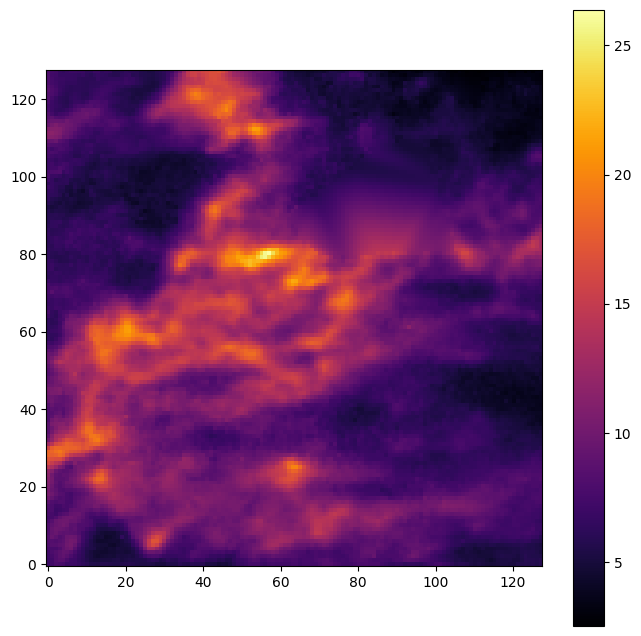

In [90]:
#Plot total column density map
plt.figure(figsize=(8,8))
plt.imshow(NHI, origin="lower", cmap="inferno")
plt.colorbar()

In [91]:
#Fourier all cube along v axis
hfreqs = np.fft.rfftfreq(cube.shape[0], dv)

hsfft = np.zeros((len(hfreqs),cube.shape[1],cube.shape[2]))
for i in tqdm(np.arange(cube.shape[1])):
    for j in np.arange(cube.shape[2]):
        s = cube[:,i,j]
        #Apodization
        tapper = ml.apodize_1d(0.9,len(s))
        s_apod = s * tapper
        hsfft[:,i,j] = np.abs(rfftn(s_apod))
        #Normalization by total NHI (FFT at k=0)
        hsfft[:,i,j] /= hsfft[0,i,j]

#Selected kv cut (see paper)
kcut = 0.12

100%|██████████| 128/128 [00:01<00:00, 115.53it/s]


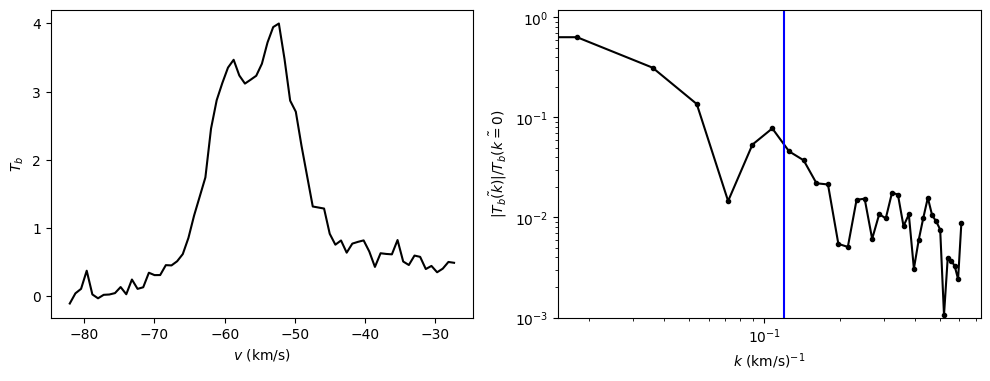

In [92]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
x = 39; y = 17
ax1.plot(v, cube[:,x,y], "-k")
ax1.set_ylabel(r"$T_b$")
ax1.set_xlabel(r"$v$ (km/s)")
ax2.plot(hfreqs, hsfft[:,x,y], ".-k")
ax2.plot([kcut, kcut], [0,2], "-b")
ax2.set_ylim([1.e-3,1.2])
# ax2.set_xlim(-70,-40)
ax2.set_ylabel(r"|$\tilde{T_b(k)}$|/$\tilde{T_b(k=0)}$")
ax2.set_xlabel(r"$k$ (km/s)$^{-1}$")
ax2.set_xscale("log")
ax2.set_yscale("log")

In [93]:
klim = np.where(np.sort(hfreqs) > kcut)[0][0]
print(klim, hfreqs[klim])
fcnm_low = np.max(hsfft[klim:],0)

7 0.1256763394186369


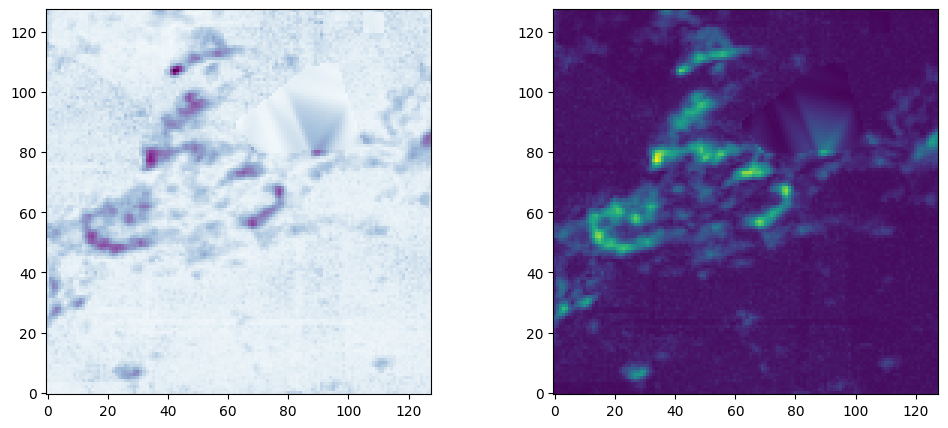

In [94]:
#Plot mass fraction map
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.imshow(fcnm_low, origin="lower", vmin=0.,
          cmap="BuPu")
ax2.imshow(fcnm_low*NHI, origin="lower", vmin=0.,
          cmap="viridis")

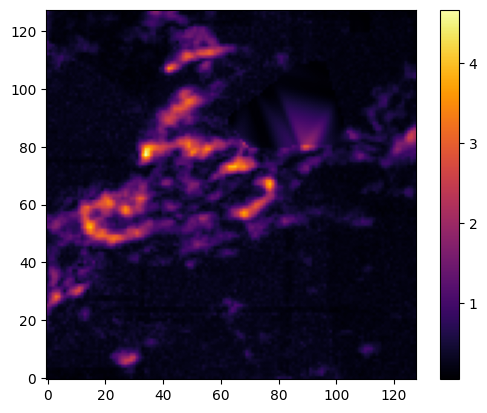

In [95]:
plt.imshow(fcnm_low*NHI, origin="lower",
          cmap="inferno")
# plt.title(str(name))
plt.colorbar()

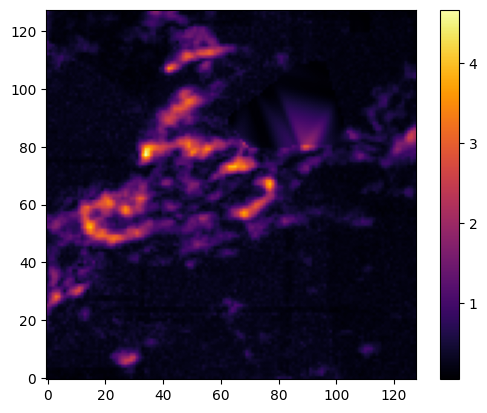

In [96]:
cnm_fft = np.where(fcnm_low*NHI != fcnm_low*NHI, 0, fcnm_low*NHI)

plt.imshow(cnm_fft, origin="lower",
          cmap="inferno")
# plt.title(str(name))
plt.colorbar()

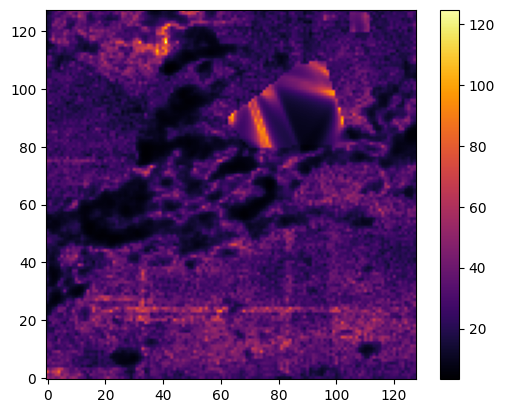

In [97]:
diff = cnm_fft/(np.max(cnm_fft)) - NHI/(np.max(NHI))

plt.imshow(NHI/cnm_fft, origin="lower",
          cmap="inferno")
# plt.title(str(name))
plt.colorbar()

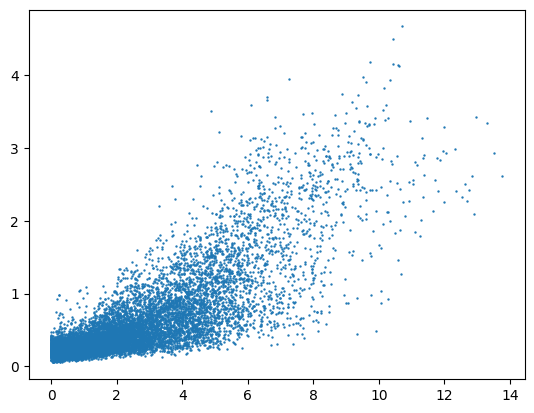

In [98]:
plt.scatter(NHI_cnmmodel.flatten(),cnm_fft.flatten(), s=0.5 )

In [99]:
# def f(x,a,b):
#   return a*x + b

def f(x,a):
  return a*x


from scipy.optimize import curve_fit
ydata = cnm_fft.flatten()
xdata = NHI_cnmmodel.flatten()
popt, pcov = curve_fit( f, xdata, ydata )

print(popt)

[0.2285028]


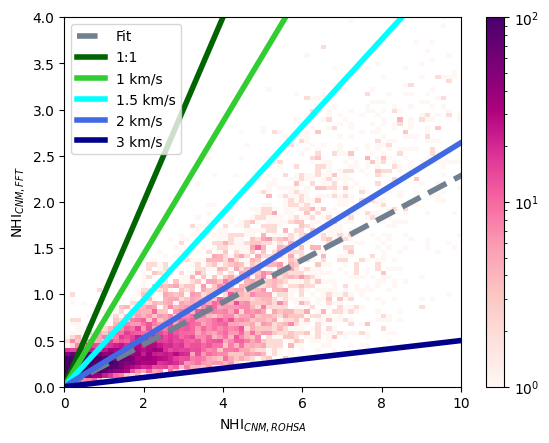

In [107]:
import matplotlib
x_sim = np.linspace(0,25,50)
# plt.scatter(NHI.flatten(),cnm_fft.flatten() )
plt.hist2d(NHI_cnmmodel.flatten(),cnm_fft.flatten(), cmap = 'RdPu', bins=100,norm=matplotlib.colors.LogNorm(vmax=100))
plt.plot(x_sim,f(x_sim, *popt), linewidth=4, color='slategrey',linestyle='--', label='Fit')
plt.plot(x_sim,f(x_sim, 1), linewidth=4, color='darkgreen', label='1:1')
plt.plot(x_sim,f(x_sim, 0.717), linewidth=4, color='limegreen', label='1 km/s')
plt.plot(x_sim,f(x_sim, 0.47), linewidth=4, color='cyan', label='1.5 km/s')
plt.plot(x_sim,f(x_sim, 0.26416), linewidth=4, color='royalblue', label='2 km/s')
plt.plot(x_sim,f(x_sim, 0.05), linewidth=4, color='darkblue', label='3 km/s')
plt.ylim(0,4)
plt.xlim(0,10)
plt.ylabel(r'NHI$_{CNM, FFT}$')
plt.xlabel(r'NHI$_{CNM, ROHSA}$')

plt.colorbar()
plt.legend()

In [82]:
const=3
print(np.exp(-0.3328*((2)**2)))

0.2641600789337457


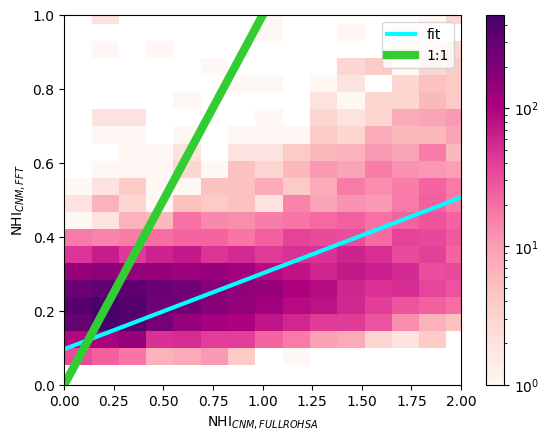

In [49]:
import matplotlib
x_sim = np.linspace(0,25,50)
# plt.scatter(NHI.flatten(),cnm_fft.flatten() )
plt.hist2d(NHI_cnmmodel.flatten(),cnm_fft.flatten(), cmap = 'RdPu', bins=100,norm=matplotlib.colors.LogNorm())
plt.plot(x_sim,f(x_sim, *popt), linewidth=3, color='cyan', label='fit')
plt.plot(x_sim,f(x_sim, 1,0), linewidth=6, color='limegreen', label='1:1')
plt.ylim(0,1)
plt.xlim(0,2)
plt.ylabel(r'NHI$_{CNM, FFT}$')
plt.xlabel(r'NHI$_{CNM, FULL ROHSA}$')

plt.colorbar()
plt.legend()
